#### Applying Machine Learning Techniques to Statcast Pitch Data

+ This will evaluate model performance of K-Nearest Neighbors and Random Forest Classifier machine learning methods. 

#### Loading Packages

In [14]:
from pybaseball import statcast_pitcher, playerid_lookup
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pybaseball import pitching_stats
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy import stats
from scipy.stats import randint

#### Gathering Data

+ I created a function to gather pitch-level data from Statcast for a specified time. For the purpose of this analysis, I will be using pitches from the 2023 season to generate a model to predict pitch type based on ball flight data.
+ The season_pitch_data function compiles a list of names of pitches who appeared during the desired date range. These names were then split to match the format required to be run through the get_data function. Each pitcher's pitch-level data for the season was then comppiled into a dataframe, which then contained all pitches thrown for the 2023 season. 
+ The two most important errors when creating the function were as follows:
1. Too Many Values to Unpack Error: Using PyBaseball's pitching_stats function, I was able to get a list of names of FanGraphs-qualified pitchers from the 2023 season. To be used in the get_data() function I created, names had to be separated by first and last name but the string splitting had to be done in a way that mirrored the format in Statcast's data.
2. Out-of-Bounds Single Positional Indexer Error: I did a bunch of digging in an attempt to remedy this error but didn't find much that would allow me to work through it. Doing my best with my current skill level and acknowledging I would still have tens of thousands of data points to work with, I chose to skip over names that incurred this error using the try-except method. Names such a Pablo Lopez or Nestor Cortes (and a handful of others) would result in error even when trying to individually load Statcast data. 

In [16]:
# Simple function to create a one-step process to retrieve pitch-level data 
def get_data(last_name, first_name, start_date, end_date):
    id_df = playerid_lookup(last_name, first_name)
    id = id_df['key_mlbam'].iloc[0]
    data = statcast_pitcher(start_date, end_date, player_id = id)
    return data

In [18]:
def season_pitch_data(start_date, end_date):
    
    start_year = datetime.strptime(start_date, '%Y-%m-%d').year
    end_year = datetime.strptime(end_date, '%Y-%m-%d').year
    # Fetch pitching stats data
    pitching_stats_data = pitching_stats(start_year, end_year, qual=1)
    
    # Extract player names
    player_names = pitching_stats_data['Name'].tolist()
    
    # Initialize an empty list to hold dataframes
    df = []

    # Process each player name
    for full_name in player_names:
        
        parts = full_name.split()
        first_name = parts[0]
        last_name = ' '.join(parts[1:])
    # Run get_data for each player
        try:
            player_data = get_data(last_name, first_name, start_date, end_date)
            if not player_data.empty:
                df.append(player_data)
        except Exception as e:
            print(f"Error retrieving data for {full_name}: {e}")
        
    # Concatenate all dataframes into one
    all_pitches = pd.concat(df, ignore_index=True)
    
    return all_pitches

+ Data was compiled, sampled to ensure it matched my desired output, then saved to a CSV to avoid needing to run the function again as it took quite a while to execute. 

#### Data Prep

In [20]:
# Loading Data
df = pd.read_csv('/Users/will/Documents/Portfolio/all_pitches.csv')

In [22]:
# Keep only necessary columns
df = df[['pitch_type', 'release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 
                           'ax', 'ay', 'az', 'release_spin_rate', 'release_extension', 'spin_axis']]

In [24]:
# This will show the total number of pitches in our dataset
# With over 600,000 observations, we will have to operate on a subset of data in consideration of time and computational cost
df.shape

(626411, 15)

In [26]:
# Using sample() method, we're gonna operate on just 10% of our data 
df_sample = df.sample(62600)

In [28]:
#check for null values
for col in df_sample.columns:
    print(f'{col}: {df_sample[col].isnull().sum()}')

pitch_type: 90
release_speed: 90
release_pos_x: 90
release_pos_z: 90
pfx_x: 90
pfx_z: 90
vx0: 90
vy0: 90
vz0: 90
ax: 90
ay: 90
az: 90
release_spin_rate: 417
release_extension: 182
spin_axis: 417


In [30]:
# There are so many datapoints in this dataset that we can drop all rows with null values
# The importance keeping the critical metrics of spin rate and axis greatly outweights the minimal loss in data
df_sample.dropna(axis =0, inplace = True)

In [32]:
df_sample['pitch_type'].value_counts()

pitch_type
FF    19907
SL    10759
SI     9323
CH     6594
FC     4954
CU     4212
ST     3303
FS     1394
KC     1349
SV       95
FO       93
FA       89
EP       54
KN       15
PO        6
SC        5
CS        4
Name: count, dtype: int64

In [34]:
# Removing Eephus (EP) and pitch-out (PO), FA (which I believe is an outdated code for 4-seam fastball, but we'll remove them for now), 
# SC, KN, SV, FO because of their very low frequency in the data (presented issue when running cross validation for find optimal number of 
# neighbors), and CS (unsure what this is and haven't been able to find an answer)
data = df_sample[~df_sample['pitch_type'].isin(['SV', 'FO', 'FA', 'EP', 'KN', 'PO', 'SC', 'CS'])].copy()
data['pitch_type'].value_counts()

pitch_type
FF    19907
SL    10759
SI     9323
CH     6594
FC     4954
CU     4212
ST     3303
FS     1394
KC     1349
Name: count, dtype: int64

#Initialize encoder then encode pitch_type (Y)
label_encoder = LabelEncoder()
data['pitch_type_enc'] = label_encoder.fit_transform(data['pitch_type'])

#### K-Nearest Neighbors

In [36]:
# Check for outliers
def find_outliers(data):
    z_scores = stats.zscore(data)
    threshold = 3
    outliers = (abs(z_scores) > threshold).any(axis=1)
    return outliers

In [40]:
# Separating features by data type to remove outliers, then recombining them into a single, clean dataframe

num_data = data[['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 
                 'ax', 'ay', 'az', 'release_spin_rate', 'release_extension', 'spin_axis']]
cat_data = data[['pitch_type']]

outliers = find_outliers(num_data)

clean_num = num_data[~outliers]
clean_cat = cat_data[~outliers]

clean_data = pd.concat([clean_cat, clean_num], axis = 1)

In [42]:
# Define features
features = clean_data[['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 
                           'ax', 'ay', 'az', 'release_spin_rate', 'release_extension', 'spin_axis']]

# Using the standard scaler since we must scale data to effecitvely run KNN model
scaler = StandardScaler()
scaled_data = scaler.fit_transform(features)

In [46]:
# Scaling the data turns it into a numpy array, so we're gonna change it to a pandas df
scaled_df = pd.DataFrame(scaled_data, columns = features.columns)

In [48]:
# Define features
X = scaled_df
y = clean_data['pitch_type']

In [50]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 42)

In [52]:
# Initialize KNN
knn = KNeighborsClassifier()

# Set the range of neighbor values we want to test
param_dist = {'n_neighbors': randint(1, 21)}

# Run Randomized Search Cross Validation to find optimal number of neighbors
random_search = RandomizedSearchCV(estimator = knn, param_distributions = param_dist, n_iter = 10, cv = 5, scoring = 'accuracy')

# Traiing our model
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(),
                   param_distributions={'n_neighbors': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x30b0df890>},
                   scoring='accuracy')

In [54]:
# Get the optimal number of neighbors
optimal_neighbors = random_search.best_params_['n_neighbors']
optimal_neighbors

5

In [56]:
# Get the RSCV accuracy score for our optimal number of neighbors
best_score = random_search.best_score_
best_score

0.8927359734586764

In [58]:
# Taking a look at the output of our RSCV 
cvresults = pd.DataFrame(random_search.cv_results_)
cvresults

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.054682,0.001295,0.962575,0.002545,6,{'n_neighbors': 6},0.889420,0.887627,0.893113,0.886896,0.890722,0.889556,0.002228,3
1,0.053767,0.000400,1.059439,0.003206,8,{'n_neighbors': 8},0.890018,0.888344,0.892994,0.887135,0.890244,0.889747,0.001982,2
2,0.053300,0.000215,1.284008,0.005713,18,{'n_neighbors': 18},0.882367,0.879139,0.884146,0.877451,0.879125,0.880446,0.002442,9
3,0.053686,0.000332,1.136393,0.009779,11,{'n_neighbors': 11},0.886432,0.889301,0.889168,0.883668,0.890842,0.887882,0.002541,4
4,0.053835,0.000464,1.279393,0.009363,17,{'n_neighbors': 17},0.882247,0.879857,0.885820,0.878407,0.882592,0.881785,0.002541,8
5,0.053544,0.000464,0.621002,0.001991,1,{'n_neighbors': 1},0.875075,0.879498,0.875060,0.877929,0.878527,0.877218,0.001826,10
6,0.054107,0.000318,1.231742,0.011718,14,{'n_neighbors': 14},0.884519,0.881530,0.885581,0.883668,0.884864,0.884032,0.001394,7
7,0.053969,0.000199,1.202410,0.011379,13,{'n_neighbors': 13},0.886910,0.886551,0.887614,0.882951,0.886059,0.886017,0.001615,6
8,0.053719,0.000364,1.134919,0.004754,11,{'n_neighbors': 11},0.886432,0.889301,0.889168,0.883668,0.890842,0.887882,0.002541,4
9,0.053667,0.000497,0.934370,0.012501,5,{'n_neighbors': 5},0.890735,0.890855,0.893113,0.891440,0.897537,0.892736,0.002546,1


In [60]:
# Saving our top model to be used on our test data
best_knn = random_search.best_estimator_

In [62]:
# Predicting values using the test data
y_predicted = best_knn.predict(X_test)

In [64]:
# Checking the accuracy score of the model
accuracy = accuracy_score(y_test, y_predicted)
print(accuracy)

0.8984100418410041


In [68]:
# Classification report to show breakdown of model performance on each class/pitch type
knn_classification_report = classification_report(y_test, y_predicted)
print(knn_classification_report)

              precision    recall  f1-score   support

          CH       0.93      0.93      0.93      1955
          CU       0.86      0.87      0.87      1174
          FC       0.82      0.78      0.80      1488
          FF       0.95      0.97      0.96      5782
          FS       0.77      0.63      0.69       254
          KC       0.77      0.74      0.76       400
          SI       0.93      0.91      0.92      2756
          SL       0.85      0.87      0.86      3180
          ST       0.83      0.79      0.81       936

    accuracy                           0.90     17925
   macro avg       0.86      0.83      0.84     17925
weighted avg       0.90      0.90      0.90     17925



+ With an accuracy score just shy of .90, this model performs quite well at classifying pitch type.
+ Splitters (FS) had a large disparity between precision and recall. The model's precision - correctness of positive classification - shows us that when the model did classify a pitch as a splitter, it did so with a relatively subpar level of accuracy. However, the much lower recall scores tells us that the model had a lot of false negatives when classifying splitters. This could be explained by the very, very low number of observations of splitters in the dataset.
+ The model also performed relatively poorly on knuckle-curves (KC). This could make sense as the KC is a variation of a traditional curveball (CU) but is generally thrown harder. The model could've had difficulty distinguishing between the two to some degree, which may have been a result of the very few number of KC in the data. 

#### Random Forest Classifier

In [102]:
#Initialize encoder then encode pitch_type (Y)
# RF doesn't need to be encoded, but I can use it to effectively map pitch_type which will simplify the creation of 
# dataframes to display score metrics of the model
label_encoder = LabelEncoder()
data['pitch_type_enc'] = label_encoder.fit_transform(data['pitch_type'])

In [90]:
# Defining features before splitting data
X = data[['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 
                           'ax', 'ay', 'az', 'release_spin_rate', 'release_extension', 'spin_axis']]
y = data['pitch_type_enc']

In [92]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 42)

In [94]:
# Fitting the model on the training data
# Our first model will be with default Random Forest settings
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [96]:
y_predicted = rf.predict(X_test)

In [114]:
accuracy = accuracy_score(y_test, y_predicted)
precision = precision_score(y_test, y_predicted, average = None)
recall = recall_score(y_test, y_predicted, average = None)

print('Overall Accuracy Score: ', accuracy)

Overall Accuracy Score:  0.8849452505528885


In [139]:
# Grabbing the class name (pitch type) for each class number
class_names = label_encoder.classes_

# Precision and Recall scores for each pitch_type
precision_df = pd.DataFrame({'Pitch' : class_names, 
                                'Precision' : precision})

recall_df = pd.DataFrame({'Pitch' : class_names, 
                                'Recall' : recall})

print(f'\n {precision_df}')
print(f'\n {recall_df}')


   Pitch  Precision
0    CH   0.898130
1    CU   0.847859
2    FC   0.816246
3    FF   0.949717
4    FS   0.926045
5    KC   0.870849
6    SI   0.926541
7    SL   0.792896
8    ST   0.789419

   Pitch    Recall
0    CH  0.946086
1    CU  0.870487
2    FC  0.696501
3    FF  0.971070
4    FS  0.654545
5    KC  0.540046
6    SI  0.911402
7    SL  0.875672
8    ST  0.754212


In [120]:
# Running RandomSearchCV to see if we can improve the model 
# Set dictionary to hyperparamters to be iterated through
rf_param_dist = {'n_estimators': randint(10, 100), 
                 'max_depth': randint(1,20)}

#run Randomized Search Cross Validation to find optimal number of neighbors
rf_random_search = RandomizedSearchCV(estimator = rf, param_distributions = rf_param_dist, n_iter = 10, cv = 5, scoring = 'accuracy')

#traiing our model
rf_random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x30b1ae1e0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x30b1ad760>},
                   scoring='accuracy')

In [122]:
# Displaying the best paramters from our random search
rf_random_search.best_params_

{'max_depth': 17, 'n_estimators': 49}

In [124]:
# Saving best model from above
rf_best = rf_random_search.best_estimator_

In [126]:
y_pred = rf_best.predict(X_test)

In [128]:
# Evaluating model performance
rf_best_acc = accuracy_score(y_test, y_pred)

print('Accuracy Score: ', rf_best_acc)

Accuracy Score:  0.8793354549867847


In [130]:
#grabbing the class name (pitch type) for each class number
class_names = label_encoder.classes_

# Evaluating model performance
rf_best_prec = precision_score(y_test, y_pred, average = None)
rf_best_rec = recall_score(y_test, y_pred, average = None)

#Precision and Recall score were calculated for each pitch_type then added to a df with corresponding pitch_type
precision_scores = pd.DataFrame({'Pitch' : class_names, 
                                'Precision' : rf_best_prec})

recall_scores = pd.DataFrame({'Pitch' : class_names, 
                                'Recall' : rf_best_rec})

print(f'\n Precision Scores for Best Model \n{precision_scores}')
print(f'\n Recall Scores for Best Model \n{recall_scores}')


 Precision Scores for Best Model 
  Pitch  Precision
0    CH   0.889268
1    CU   0.841777
2    FC   0.816083
3    FF   0.948477
4    FS   0.923611
5    KC   0.867159
6    SI   0.921806
7    SL   0.781179
8    ST   0.777663

 Recall Scores for Best Model 
  Pitch    Recall
0    CH  0.945049
1    CU  0.847724
2    FC  0.689771
3    FF  0.967763
4    FS  0.604545
5    KC  0.537757
6    SI  0.911765
7    SL  0.871876
8    ST  0.745292


+ Unlike the KNN, we see a much better precision score for splitters. However, the recall score for splitters was much lower.
+ The model also had more difficulty classifying cutters comapred to KNN.
+ Overall, it seems that despite comparable accuracy scores, the RF model was more inconsistent than the KNN model above. There was better performance with precision - when the RF model predicted a certain pitch type it was usually correct (few false positives). The recall scores showed that there was a high number false negatives - pitches that were not classified as a certain pitch type despite being that pitch type. It makes sense that pitches with fewer observations had larger differences in scores as the cost of making a mistake would be higher.
+ My assumption for why the default random forest model had higher scores is that I limited tree depth with running RandomSearchCV. I would expect increasing the max_depth range would yield better results but both models preformed well and the difference in performance was not too drastic.

In [132]:
# Visualizing feature importance 
feature_importances = pd.Series(rf_best.feature_importances_, index=X_train.columns).sort_values(ascending = False)

<Axes: >

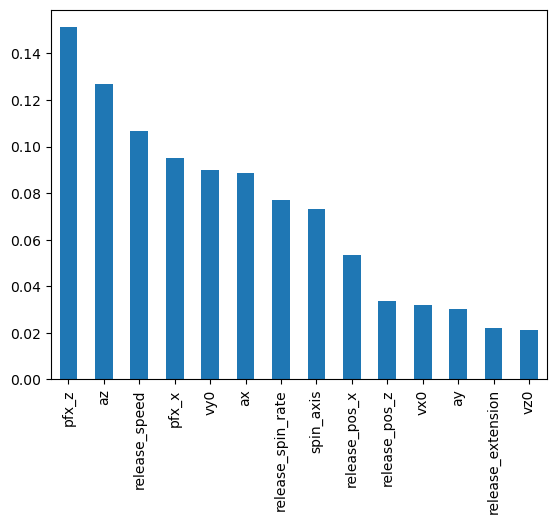

In [134]:
feature_importances.plot.bar()

+ The plot above displays which features were most influential in determining how to assign each pitch to a class.
+ The movement profile of the pitch logically makes sense to be very critical when assigning class - pfx_z (vertical movement) and pfx_x (horizontal movement)
+ The high importance of vertical acceleration (az) makes sense as well and is best shown by looking at two ends of the spectrum in terms of ball flight - four-seam fastballs and curveballs. Below I have displayed mean az based on pitch type. We see that four-seam fastballs have by far the lowest negative accleration and curveballs (both traditional and knuckle) have the highest. Four-seams experience a lesser effective of gravity - 'ride' or 'carry' is an important characteristic in evaluating a four-seamer - while curveballs are defined by their negative vertical movement - the sharper, the better.

In [136]:
data.groupby('pitch_type')[['pfx_x', 'pfx_z', 'ax', 'az']].agg('mean')

,pfx_x,pfx_z,ax,az
pitch_type,,,,
CH,-0.423180,0.477247,-5.030678,-26.675497
CU,0.329008,-0.819886,2.800218,-39.376698
FC,0.128631,0.648658,0.926425,-24.039795
FF,-0.269669,1.312813,-4.100792,-14.746720
FS,-0.874247,0.265459,-10.465808,-28.697387
KC,0.455404,-0.778540,3.845458,-39.403013
SI,-0.586672,0.650626,-8.135538,-23.374470
SL,0.257192,0.120648,2.184980,-30.464584
ST,0.613645,0.126533,5.623668,-30.917620
